<a href="https://colab.research.google.com/github/samiHEL/ML_Intro_Regression/blob/main/Random_Forest_for_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Connexion drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Partie activité fraude**

In [2]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report
!pip install h2o
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator

%matplotlib inline



data = pd.read_csv(r'/content/drive/MyDrive/Fraud_Data.csv', parse_dates=['signup_time', 'purchase_time'])
data['ip_address'] = data['ip_address'].astype(int)



address2country = pd.read_csv(r'/content/drive/MyDrive/IpAddress_to_Country.csv')
#address2country.head()
data.head()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 MB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.42.0.3-py2.py3-none-any.whl size=240945068 sha256=2ae23eb74b024ce64e54ab4bc647a61f872914b47cc010b7ac7a48246e77becc
  Stored in directory: /root/.cache/pip/wheels/f9/7d/1d/e1258f0558603969a8393cb5b22a18e313337f01627a118302
Successfully built h2o


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117,0


In [3]:
#convert int
data['ip_address'] = data['ip_address'].astype(int)
address2country['lower_bound_ip_address']=address2country['lower_bound_ip_address'].astype(int)
#Merge
df_merged =pd.concat([data, address2country], axis=1)

# Filter
df_filtered = df_merged[

    ( df_merged["ip_address"] >= df_merged["lower_bound_ip_address"])
    & (df_merged["ip_address"] >= df_merged["upper_bound_ip_address"])
]
df_filtered.head()
# Selection des colonnes
df_final = df_filtered[["user_id", "signup_time", "purchase_time", "purchase_value", "device_id", "source", "browser", "sex", "age", "ip_address", "class", "country"]]
df_final.head()
# reviser metrics, regression, falsification pour interro

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368,0,Australia
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387,0,China
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820,1,China
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443,0,Australia
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117,0,China


In [4]:
df_final['time_diff'] = ((df_final['purchase_time'] - df_final['signup_time']).dt.total_seconds() / 3600).astype(int)  # Time difference in hours
df_final.head()
# Check user number for unique devices
df_final['device_num'] = df_final.groupby('device_id')['user_id'].transform('nunique')
# Check user number for unique ip_address
df_final['ip_num'] = df_final.groupby('ip_address')['user_id'].transform('nunique')
# Signup day and week
df_final['signup_day'] = df_final['signup_time'].dt.dayofweek
df_final['signup_week'] = df_final['signup_time'].dt.isocalendar().week
# Purchase day and week
df_final['purchase_day'] = df_final['purchase_time'].dt.dayofweek
df_final['purchase_week'] = df_final['purchase_time'].dt.isocalendar().week
df_final.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_num,ip_num,signup_day,signup_week,purchase_day,purchase_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368,0,Australia,1251,1,1,1,9,5,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387,0,China,4,1,1,6,23,0,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820,1,China,0,4,4,3,1,3,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443,0,Australia,136,1,1,1,18,0,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117,0,China,1211,1,1,1,30,2,37


In [5]:
# Definissons les features et target utilisés
final_data = df_final.drop(columns=['signup_time', 'purchase_time', 'device_id', 'ip_address', 'user_id'])
cols_order = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 'source', 'browser', 'sex', 'age', 'country', 'time_diff', 'device_num', 'ip_num', 'class']
final_data = final_data[cols_order]
final_data.head()

,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,country,time_diff,device_num,ip_num,class
0,1,9,5,16,34,SEO,Chrome,M,39,Australia,1251,1,1,0
1,6,23,0,24,16,Ads,Chrome,F,53,China,4,1,1,0
2,3,1,3,1,15,SEO,Opera,M,53,China,0,4,4,1
3,1,18,0,19,44,SEO,Safari,M,41,Australia,136,1,1,0
4,1,30,2,37,39,Ads,Safari,M,45,China,1211,1,1,0


X_train : (35900, 13)
X_test : (15386, 13)
y_train : (35900,)
y_test : (15386,)
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.20" 2023-07-18; OpenJDK Runtime Environment (build 11.0.20+8-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.20+8-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpjv21hfj7
  JVM stdout: /tmp/tmpjv21hfj7/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpjv21hfj7/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,11 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,8 days
H2O_cluster_name:,H2O_from_python_unknownUser_klty64
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     13949
           1       1.00      0.54      0.70      1437

    accuracy                           0.96     15386
   macro avg       0.98      0.77      0.84     15386
weighted avg       0.96      0.96      0.95     15386



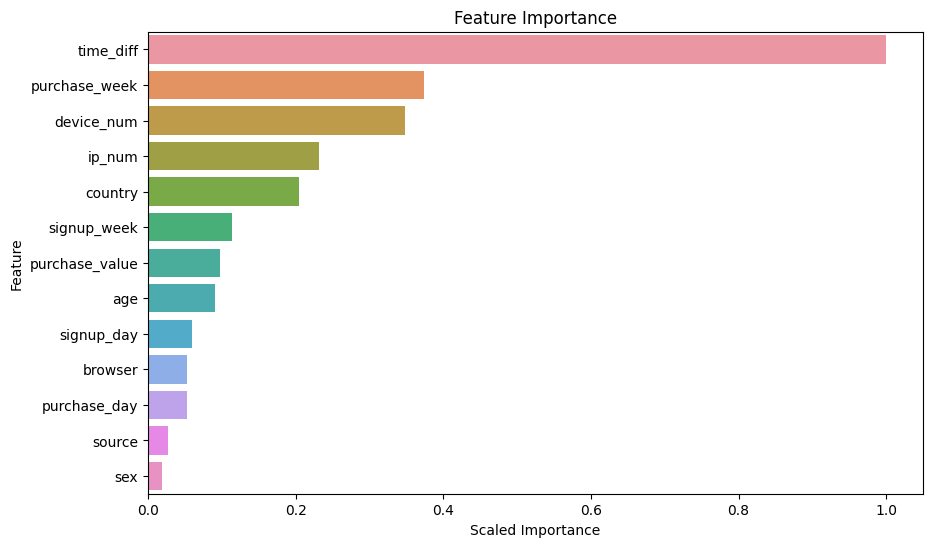

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report
from sklearn.model_selection import train_test_split

X = final_data.drop(columns=['class'])
y = final_data['class']


# Split into 70% training and 30% test dataset
# Define features and target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("X_train :", X_train.shape)
print("X_test :", X_test.shape)
print("y_train :", y_train.shape)
print("y_test :", y_test.shape)

# Build random forest model
h2o.init()
train = h2o.H2OFrame(pd.concat([X_train, y_train], axis=1))
test = h2o.H2OFrame(pd.concat([X_test, y_test], axis=1))
predictors = X_train.columns.tolist()
response = 'class'
drf = H2ORandomForestEstimator(ntrees=50, max_depth=20, nfolds=10)
drf.train(x=predictors, y=response, training_frame=train)

feature_importances = drf.varimp(use_pandas=True)

# seaborn barplot for feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='scaled_importance', y='variable', data=feature_importances.sort_values(by='scaled_importance', ascending=False))
plt.title("Feature Importance")
plt.xlabel("Scaled Importance")
plt.ylabel("Feature")
plt.savefig("feature_barplot.png")

# Classification report
predictions_h2o = drf.predict(test)
predictions_df = predictions_h2o.as_data_frame()
threshold = 0.5
predictions_df['predict'] = (predictions_df['predict'] > threshold).astype(int)
classification_rep = classification_report(y_test, predictions_df['predict'])

print("Classification Report:")
print(classification_rep)

# **On peut dire ici que l'ensemble de données est déséquilibré. La methodologie est bonne mais il faut un dataset avec plus de fraudeur. Probléme repartition de donnée.**

In [7]:
#tracer la courbe ROC et calculer l'AUC